# Bathymetry

* Follow the process in Michael's
  https://github.com/SalishSeaCast/analysis-michael/blob/master/bathymetry/bathymetry-201702.ipynb
  notebook to create the base bathymetry for the 202405 coordinates and double resolution coordinates

In [1]:
import os
from pathlib import Path
import sys

import cmocean
import numpy
import matplotlib.pyplot as plt
import xarray

Python and library versions:

In [2]:
import bottleneck
import h5netcdf
import h5py
import matplotlib
import netCDF4
import pandas
import pyproj
import scipy

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{pandas.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{netCDF4.__version__=}")
print(f"{scipy.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{cmocean.__version__=}")
print(f"{pyproj.__version__=}")

Python sys.version='3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]'
numpy.__version__='1.26.4'
xarray.__version__='2024.6.0'
bottleneck.__version__='1.4.0'
pandas.__version__='2.2.2'
h5netcdf.__version__='1.3.0'
h5py.__version__='3.11.0'
netCDF4.__version__='1.6.5'
scipy.__version__='1.14.0'
matplotlib.__version__='3.8.4'
cmocean.__version__='v3.0.3'
pyproj.__version__='3.6.1'


We need functions from several modules in `analysis-michael/bathymetry/` but they are not packaged.
So,
add their paths in an adjacent clone into `sys.path`.

**This is a expedient hack.
Please don't copy it unless you really know why you are doing it.**

In [3]:
# isolate the probable user-specific part of repo paths to make the notebook portable
repos_prefix = Path("/media/doug/warehouse/MEOPAR/")

In [4]:
sys.path.insert(3, os.fspath(repos_prefix / Path("analysis-michael", "bathymetry")))

sys.path

['/media/doug/warehouse/MEOPAR/analysis-doug',
 '/home/doug/conda_envs/2xrez-202111/lib/python312.zip',
 '/home/doug/conda_envs/2xrez-202111/lib/python3.12',
 '/media/doug/warehouse/MEOPAR/analysis-michael/bathymetry',
 '/home/doug/conda_envs/2xrez-202111/lib/python3.12/lib-dynload',
 '',
 '/home/doug/conda_envs/2xrez-202111/lib/python3.12/site-packages']

In [5]:
import bathy_helpers
import bathy_prepare

In [6]:
# isolate the probable user-specific part of repo paths to make the notebook portable
repos_prefix = Path("/media/doug/warehouse/MEOPAR/")

coords_paths = {
    "djl_202405": repos_prefix / "grid" / "coordinates_SalishSeaCast_202405.nc",
    "dbl_202405": repos_prefix / "grid" / "coordinates_SalishSeaCast_double_202405.nc",
}

In [7]:
pnw_coast_paths = {
    "coastline": Path("/ocean/rich/more/mmapbase/bcgeo/PNW.mat"),
    "rivers": Path("/ocean/rich/more/mmapbase/bcgeo/PNWrivers.mat"),
}

In [8]:
coastline = scipy.io.loadmat(pnw_coast_paths["coastline"])["ncst"]

In [9]:
rivers = scipy.io.loadmat(pnw_coast_paths["rivers"])["ncst"]

## Create 202405 Bathymetry for Future SalishSeaCast Hindcast/Production Runs

### Load and prepare coordinates lons/lats arrays

**NOTE:** All of Michael's bathymetry module functions operate on Numpy arrays.

Load lon/lat coordinate arrays of T and F grid points from coordinates file:

In [10]:
with xarray.open_dataset(coords_paths["djl_202405"], engine="h5netcdf") as coords:
    glamt = coords.glamt[0].values
    gphit = coords.gphit[0].values
    glamf = coords.glamf[0].values
    gphif = coords.gphif[0].values


Expand the F grid so that its points form complete boxes around the T grid points:

In [11]:
glamfe, gphife = bathy_helpers.expandf(glamf, gphif)


### Re-grid Bathymetry Survey Products on to the SalishSeaCast Grid

In [53]:
bathy_products_path = repos_prefix / "bathy_surveys"
bathy_paths = {
    "cascadia": bathy_products_path / "Cascadia" / "cascadia.bil",
    "chs2": bathy_products_path / "Data_From_Mitchell_CHS/",
    "bc3": bathy_products_path / "BC3" / "british_columbia_3sec.asc",
}

**NOTE:** The `bathy_prepare.prepare_*()` functions create `.npz` cache files of Numpy arrays with `numpy.savez()`.
Those files need to be deleted if a clean run is required.

In [13]:
cache = bathy_prepare.prepare_cascadia(os.fspath(bathy_paths["cascadia"]), glamt, gphit, glamf, gphif, glamfe, gphife)

cache

'/media/doug/warehouse/MEOPAR/bathy_surveys/Cascadia/cascadia.bil.results.npz'

In [14]:
locals().update(numpy.load(cache))

In [17]:
cache = bathy_prepare.prepare_chs2(f"{os.fspath(bathy_paths["chs2"])}/", glamt, gphit, glamf, gphif, glamfe, gphife)

cache

'/media/doug/warehouse/MEOPAR/bathy_surveys/Data_From_Mitchell_CHS/results.npz'

In [18]:
locals().update(numpy.load(cache))

In [19]:
cache = bathy_prepare.prepare_bc3(os.fspath(bathy_paths["bc3"]), glamt, gphit, glamf, gphif, glamfe, gphife)

cache

'/media/doug/warehouse/MEOPAR/bathy_surveys/BC3/british_columbia_3sec.asc.results.npz'

In [20]:
locals().update(numpy.load(cache))

### Create Bathymetry

Synthesis new bathymetry by weighted sum of Cascadia, BC3, and CHS2 products:

In [21]:
base_bathy = bathy_helpers.bathyblend(casmean, bc3mean, chs2mean, 1, 5, 10)

In [22]:
# Clip depth of water points to [4,428]
bathy_202405 = numpy.copy(base_bathy)
bathy_202405[(bathy_202405 > 0) & (bathy_202405 < 4)] = 4
bathy_202405[bathy_202405 > 428] = 428

Create 202405 bathymetry by setting coastline at the 2m isobath,
making the minimum water depth 4m,
and making the maximum water depth 428m:

In [23]:
bathy_202405 = numpy.copy(base_bathy)
bathy_202405[(bathy_202405 > 0) & (bathy_202405 < 2)] = 0
bathy_202405[(bathy_202405 >= 2) & (bathy_202405 < 4)] = 4
bathy_202405[bathy_202405 > 428] = 428

/tmp/ipykernel_84049/2013925461.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax_lonlat.pcolormesh(glamt, gphit, masked_bathy, cmap=cmocean.cm.deep_r, vmin=0, vmax=428)


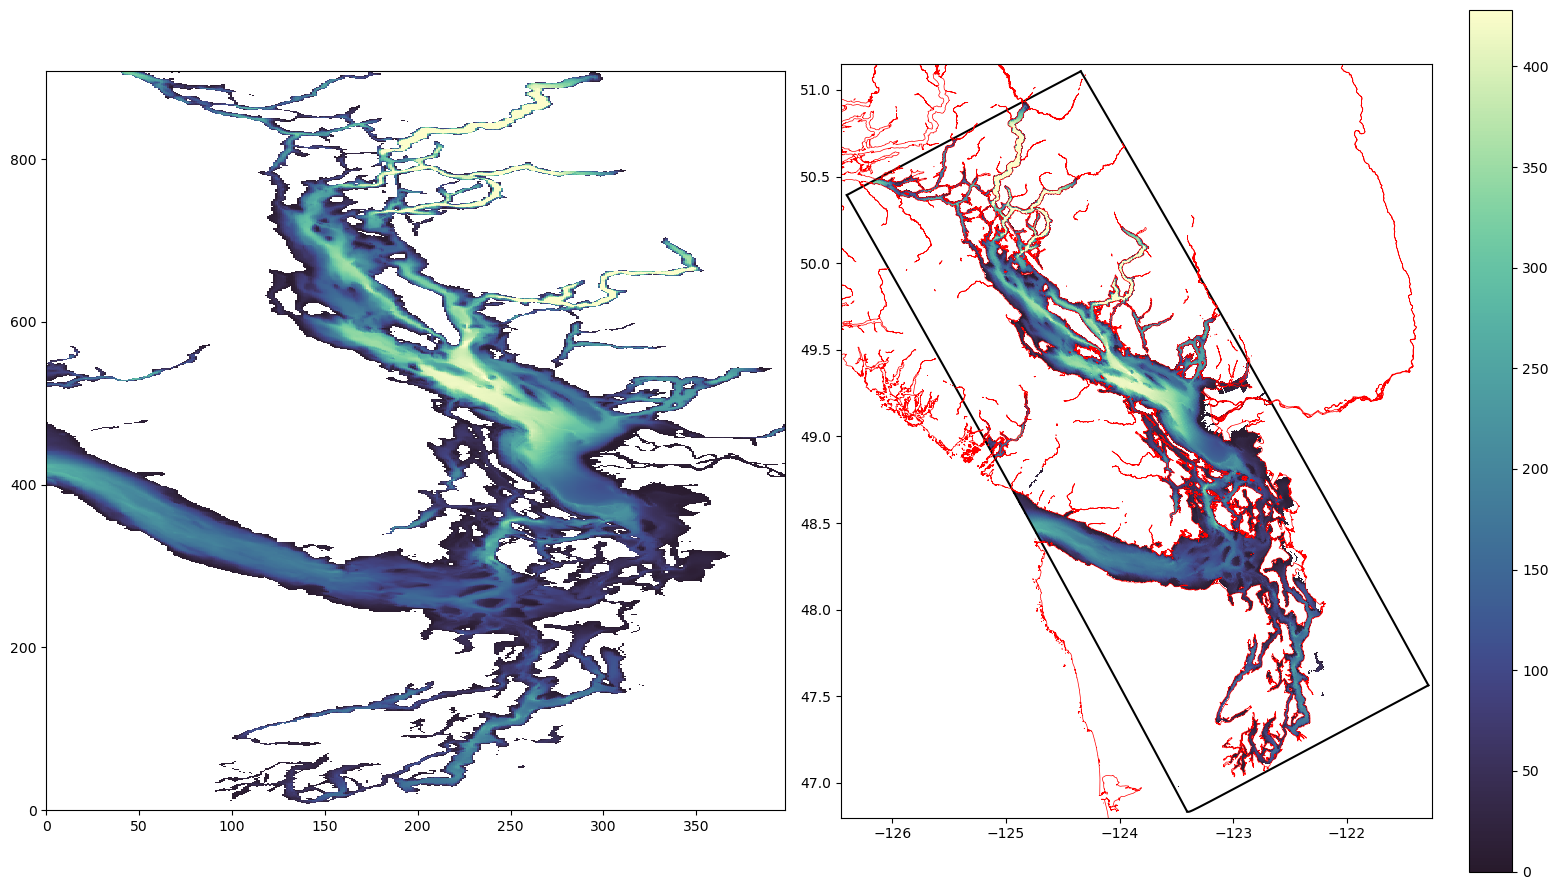

In [54]:
fix, (ax_xy, ax_lonlat) = plt.subplots(1, 2, figsize=(16, 9))
masked_bathy = numpy.ma.masked_where(bathy_202405 == 0, bathy_202405)
ax_xy.pcolormesh(masked_bathy, cmap=cmocean.cm.deep_r, vmin=0, vmax=428)
ax_xy.set_aspect(bathy_202405.shape[1] / bathy_202405.shape[0])

# SalishSeaCast domain boundaries
ax_lonlat.plot(glamf[0, :], gphif[0, :], color="black")  # south
ax_lonlat.plot(glamf[:, 0], gphif[:, 0], color="black")  # west
ax_lonlat.plot(glamf[-1, :], gphif[-1, :], color="black")  # north
ax_lonlat.plot(glamf[:, -1], gphif[:, -1], color="black")  # east

mesh = ax_lonlat.pcolormesh(glamt, gphit, masked_bathy, cmap=cmocean.cm.deep_r, vmin=0, vmax=428)
plt.colorbar(mesh)
ax_lonlat.plot(coastline[:, 0], coastline[:, 1], color="red", linewidth=0.5)
ax_lonlat.plot(rivers[:, 0], rivers[:, 1], color="red", linewidth=0.5)

ax_lonlat.set_aspect(1 / numpy.cos(numpy.median(gphit) * numpy.pi / 180))
ax_lonlat.set_xlim(-126.45, -121.25)
ax_lonlat.set_ylim(46.8, 51.15)

plt.tight_layout()